In [71]:
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as mticker
import sys
import os
from pymoo.core.problem import StarmapParallelization
sys.path.append('../')

from mpl_toolkits.mplot3d import Axes3D

from models.PymooOptimization import PortfolioOptimizationProblem
from models.distribution_calculator import DistributionCalculator

import plotly.graph_objects as go

## Making plot of objective landscape assuming only two assets.

In [72]:
df = pd.read_csv('../../data/final_daily_returns_asset_classes.csv', index_col=0)
df.index = pd.to_datetime(df.index)

In [73]:
df.head()

,REEL,PE,MSCIWORLD,IG,GOV,HY,EONIA
Date,,,,,,,
2005-10-11,0.003231,0.006833,0.004578,-0.001342,-0.001916,-0.004075,0.000053
2005-10-12,-0.003550,-0.009657,-0.007867,-0.002606,-0.001570,-0.004370,0.000057
2005-10-13,-0.018599,-0.010692,0.000588,-0.002331,-0.003062,-0.003423,0.000057
2005-10-14,-0.007856,0.001569,-0.002991,-0.000564,0.000060,0.001618,0.000057
2005-10-17,-0.003613,0.000492,0.003290,0.000458,-0.000227,0.005447,0.000057


In [74]:
df = df[['REEL', 'MSCIWORLD', 'PE']]

df.head()

,REEL,MSCIWORLD,PE
Date,,,
2005-10-11,0.003231,0.004578,0.006833
2005-10-12,-0.003550,-0.007867,-0.009657
2005-10-13,-0.018599,0.000588,-0.010692
2005-10-14,-0.007856,-0.002991,0.001569
2005-10-17,-0.003613,0.003290,0.000492


In [75]:
import multiprocessing

end_date = os.getenv("END_TRAIN_DATE")
generations = int(os.getenv("GENERATIONS"))
pop_size = int(os.getenv("POP_SIZE"))
frac_liabilities = float(os.getenv('FRAC_LIABILITIES'))

n_processes = 8  
pool = multiprocessing.Pool(n_processes)
runner = StarmapParallelization(pool.starmap)

In [76]:

assets0 = 1000000
liabilities0 = assets0 * frac_liabilities
alpha = 0.995

dist = DistributionCalculator(df)

simulated_daily_returns, simulated_cumulative_returns = dist.prefered_dist()
simulated_cumulative_lg = []

problem = PortfolioOptimizationProblem(assets0, liabilities0, df, alpha,
                                        simulated_daily_returns, simulated_cumulative_returns, simulated_cumulative_lg, convexity_plot=True, elementwise_runner=runner)

In [77]:
'''
# Define the range of weights for asset 1 and asset 2
num_points = 50  # Number of points for the grid
weights1 = np.linspace(0, 1, num_points)
weights2 = 1 - weights1  # Since weights must sum to 1

# Create a grid of weight combinations
W1, W2 = np.meshgrid(weights1, weights2)

# Calculate SCR for each weight combination
SCR_values = np.zeros_like(W1)

for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        weights = np.array([W1[i, j], W2[i, j]])
        SCR_values[i, j] = problem.calculate_scr(weights)
    print("i =", i)

# Plotting the SCR surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf = ax.plot_surface(W1, W2, SCR_values, cmap='viridis', edgecolor='k', alpha=0.8)

# Labels and title
ax.set_xlabel("Weight of Asset 1")
ax.set_ylabel("Weight of Asset 2")
ax.set_zlabel("SCR")
ax.set_title("3D Plot of SCR vs Asset Weights")

# Add a color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.show()
'''

'\n# Define the range of weights for asset 1 and asset 2\nnum_points = 50  # Number of points for the grid\nweights1 = np.linspace(0, 1, num_points)\nweights2 = 1 - weights1  # Since weights must sum to 1\n\n# Create a grid of weight combinations\nW1, W2 = np.meshgrid(weights1, weights2)\n\n# Calculate SCR for each weight combination\nSCR_values = np.zeros_like(W1)\n\nfor i in range(W1.shape[0]):\n    for j in range(W1.shape[1]):\n        weights = np.array([W1[i, j], W2[i, j]])\n        SCR_values[i, j] = problem.calculate_scr(weights)\n    print("i =", i)\n\n# Plotting the SCR surface\nfig = plt.figure(figsize=(10, 7))\nax = fig.add_subplot(111, projection=\'3d\')\n\n# Surface plot\nsurf = ax.plot_surface(W1, W2, SCR_values, cmap=\'viridis\', edgecolor=\'k\', alpha=0.8)\n\n# Labels and title\nax.set_xlabel("Weight of Asset 1")\nax.set_ylabel("Weight of Asset 2")\nax.set_zlabel("SCR")\nax.set_title("3D Plot of SCR vs Asset Weights")\n\n# Add a color bar\nfig.colorbar(surf, ax=ax, shri

In [78]:
# Define the range of weights for asset 1 and asset 2
num_points = 100  # Number of points for the grid
weights1 = np.linspace(0, 1, num_points)
weights2 = np.linspace(0, 1, num_points)

# Create a grid of weight combinations
W1, W2 = np.meshgrid(weights1, weights2)

# Compute W3 from the constraint W1 + W2 + W3 = 1
W3 = 1 - W1 - W2

# Filter out invalid combinations (weights must be between 0 and 1)
valid_indices = (W3 >= 0) & (W3 <= 1)
W1_valid = W1[valid_indices]
W2_valid = W2[valid_indices]
W3_valid = W3[valid_indices]

# Initialize an array for SCR values
SCR_values = np.zeros_like(W1_valid)

# Calculate SCR for each valid weight combination
for idx, (w1, w2, w3) in enumerate(zip(W1_valid, W2_valid, W3_valid)):
    weights = np.array([w1, w2, w3])
    SCR_values[idx] = problem.calculate_scr(weights)
    if idx % 100 == 0:  # Print progress every 100 iterations
        print(f"Calculating SCR for index {idx}, weights: {weights}")

# Plotting the SCR surface


Calculating SCR for index 0, weights: [0. 0. 1.]
Calculating SCR for index 100, weights: [0.         0.01010101 0.98989899]
Calculating SCR for index 200, weights: [0.02020202 0.02020202 0.95959596]
Calculating SCR for index 300, weights: [0.05050505 0.03030303 0.91919192]
Calculating SCR for index 400, weights: [0.09090909 0.04040404 0.86868687]
Calculating SCR for index 500, weights: [0.14141414 0.05050505 0.80808081]
Calculating SCR for index 600, weights: [0.2020202  0.06060606 0.73737374]
Calculating SCR for index 700, weights: [0.27272727 0.07070707 0.65656566]
Calculating SCR for index 800, weights: [0.35353535 0.08080808 0.56565657]
Calculating SCR for index 900, weights: [0.44444444 0.09090909 0.46464646]
Calculating SCR for index 1000, weights: [0.54545455 0.1010101  0.35353535]
Calculating SCR for index 1100, weights: [0.65656566 0.11111111 0.23232323]
Calculating SCR for index 1200, weights: [0.77777778 0.12121212 0.1010101 ]
Calculating SCR for index 1300, weights: [0.0404

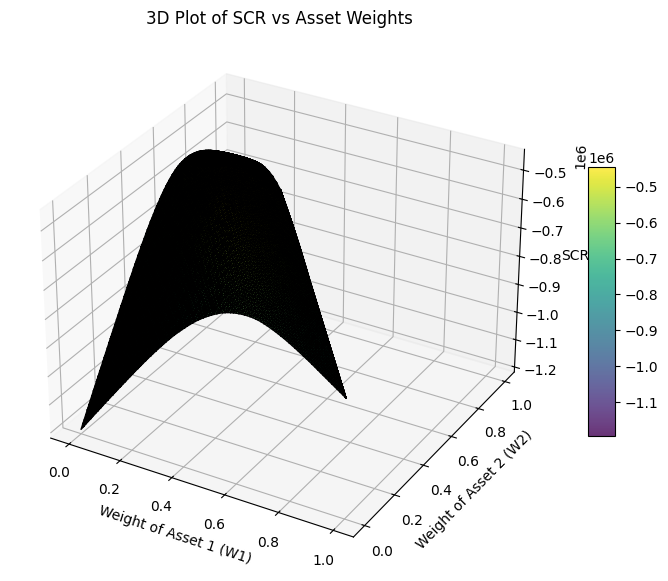

In [79]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Surface plot using only valid weights
surf = ax.plot_trisurf(W1_valid, W2_valid, SCR_values, cmap='viridis', edgecolor='k', alpha=0.8)

# Labels and title
ax.set_xlabel("Weight of Asset 1 (W1)")
ax.set_ylabel("Weight of Asset 2 (W2)")
ax.set_zlabel("SCR")
ax.set_title("3D Plot of SCR vs Asset Weights")

# Add a color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.show()

In [80]:
fig = go.Figure()

# Add the surface
fig.add_trace(go.Mesh3d(
    x=W1_valid,
    y=W2_valid,
    z=SCR_values,
    intensity=SCR_values,
    colorscale='Viridis',
    colorbar_title='SCR',
    opacity=0.8
))

# Set labels and title
fig.update_layout(
    scene=dict(
        xaxis_title="Weight of Asset 1 (W1)",
        yaxis_title="Weight of Asset 2 (W2)",
        zaxis_title="SCR",
    ),
    title="Interactive 3D Plot of SCR vs Asset Weights",
)

# Show the plot
fig.show()